In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [3]:
# Define constants for grid elements
EMPTY = 0
WALL = 1
CAPTURE_NEUTRAL = 2
CAPTURE_P1 = 3
CAPTURE_P2 = 4
PLAYER1 = 5
PLAYER2 = 6
# Define action constants
MOVE_NO = -1
MOVE_UP = 0
MOVE_DOWN = 1
MOVE_LEFT = 2
MOVE_RIGHT = 3
ATTACK = 4
DEFEND = 6
# Game settings
GRID_SIZE = 15
MAX_TURNS = 30
INITIAL_HEALTH = 100

class CombatArenaEnv:
    def __init__(self, grid_size=GRID_SIZE, max_turns=MAX_TURNS):
        self.grid_size = grid_size
        self.max_turns = max_turns
        self.turn = 0
        self.reset()
    def reset(self):
        # Create an empty grid and add random walls and capture points
        self.grid = np.full((self.grid_size, self.grid_size), EMPTY)
        self._place_walls()
        self._place_capture_points()

        # Place players in random empty positions
        self.player1 = {"position": self._get_random_empty_cell(), "health": INITIAL_HEALTH, "capture_points": 0}
        self.player2 = {"position": self._get_random_empty_cell(), "health": INITIAL_HEALTH, "capture_points": 0}

        # Mark players on the grid
        self._update_grid_positions()
        self.turn = 0
        self.render_graphic()
        return self.get_observation_for_agent(True), self.get_observation_for_agent(False)

    def _place_walls(self):
    # Randomly place a few walls
        num_walls = int(self.grid_size * self.grid_size * 0.1)  # 10% cells are walls
        for _ in range(num_walls):
            x, y = random.randint(0, self.grid_size-1), random.randint(0, self.grid_size-1)
            self.grid[x, y] = WALL
    
    def _place_capture_points(self):
        # Randomly place some capture points (neutral)
        num_points = int(self.grid_size * self.grid_size * 0.05)  # 5% cells are capture points
        for _ in range(num_points):
            x, y = random.randint(0, self.grid_size-1), random.randint(0, self.grid_size-1)
            # Place a capture point only on an empty cell
            if self.grid[x, y] == EMPTY:
                self.grid[x, y] = CAPTURE_NEUTRAL
            
    def _get_random_empty_cell(self):
            while True:
                x, y = random.randint(0, self.grid_size-1), random.randint(0, self.grid_size-1)
                if self.grid[x, y] == EMPTY:
                    return (x, y)

    def _update_grid_positions(self):
        # Clear previous player positions (set to empty or preserve capture points)
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                if self.grid[i, j] in [CAPTURE_P1, CAPTURE_P2]:
                    self.grid[i, j] = CAPTURE_NEUTRAL
                elif self.grid[i, j] in [PLAYER1, PLAYER2]:
                    self.grid[i, j] = EMPTY

        p1_x, p1_y = self.player1["position"]
        p2_x, p2_y = self.player2["position"]
        self.grid[p1_x, p1_y] = PLAYER1
        self.grid[p2_x, p2_y] = PLAYER2
    
    def get_observation_for_agent(self, is_agent_one=True):
        if is_agent_one:
            player = self.player1
            opponent = self.player2
        else:
            player = self.player2
            opponent = self.player1
            
        return {
            "grid": self.grid.copy(),
            "player": {
                "position": player["position"],
                "health": player["health"],
                "capture_points": player["capture_points"]
            },
            "opponent": {
                "position": opponent["position"],
                "health": opponent["health"]
            },
            "turn": self.turn
        }
    
    def step(self, actions):
        """
        Expects a tuple of actions (action_p1, action_p2)
        Both players act simultaneously.
        Returns:
            observation, rewards, done, info
        """
        action_p1, action_p2 = actions
        rewards = [0, 0]

        # Process player 1 action
        rewards[0] += self._process_action(self.player1, self.player2, action_p1, is_player1=True)
        # Process player 2 action
        rewards[1] += self._process_action(self.player2, self.player1, action_p2, is_player1=False)

        # Update grid positions after actions
        self._update_grid_positions()
        self.turn += 1

        # Check if game is over
        done = self.turn >= self.max_turns or self.player1["health"] <= 0 or self.player2["health"] <= 0
        info = {}
        return self.get_observation_for_agent(True),self.get_observation_for_agent(False), rewards, done, info
    
    def _process_action(self, player, opponent, action, is_player1=True):
        reward = 0
        # Get current position
        x, y = player["position"]

        # Movement: compute new position
        if action in [MOVE_NO,MOVE_UP, MOVE_DOWN, MOVE_LEFT, MOVE_RIGHT]:
            new_x, new_y = x, y
            if action == MOVE_UP:
                new_x -= 1
            elif action == MOVE_DOWN:
                new_x += 1
            elif action == MOVE_LEFT:
                new_y -= 1
            elif action == MOVE_RIGHT:
                new_y += 1

            # Check boundaries and obstacles
            if 0 <= new_x < self.grid_size and 0 <= new_y < self.grid_size:
                if self.grid[new_x, new_y] not in [WALL, PLAYER1, PLAYER2]:
                    player["position"] = (new_x, new_y)
                    if(self.grid[new_x,new_y]==CAPTURE_NEUTRAL):
                        self.grid[new_x, new_y] = CAPTURE_P1 if is_player1 else CAPTURE_P2
                        reward += 5
                        player["capture_points"] += 1
                else:
                    reward -= 1  # penalty for invalid move
            else:
                reward -= 1  # penalty for moving out of bounds

        elif action == ATTACK:
            # Check if opponent is adjacent (Manhattan distance = 1)
            opp_x, opp_y = opponent["position"]
            if abs(opp_x - x) + abs(opp_y - y) == 1:
                damage = 10
                # If opponent defended in their turn, damage reduction could be applied
                opponent["health"] -= damage
                player["capture_points"] += 5
                reward += 10  # reward for dealing damage
                # Bonus for defeating the opponent will be applied in step()
            else:
                reward -= 2  # invalid attack

        return reward

    def render_graphic(self, ax=None, fig=None):
        # Define colors for each grid element
        color_map = {
            EMPTY: "white",
            WALL: "black",
            CAPTURE_NEUTRAL: "yellow",
            CAPTURE_P1: "blue",
            CAPTURE_P2: "red",
            PLAYER1: "green",
            PLAYER2: "orange"
        }

        # If no axis is provided, create new figure
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 8))

        # Create a color grid
        color_grid = np.empty((self.grid_size, self.grid_size), dtype=object)
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                color_grid[i, j] = color_map.get(self.grid[i, j], "gray")

        # Plot the grid
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                rect = plt.Rectangle((j, self.grid_size - i - 1), 1, 1, 
                                facecolor=color_grid[i, j], edgecolor="black")
                ax.add_patch(rect)

        # Set axis limits and labels
        ax.set_xlim(0, self.grid_size)
        ax.set_ylim(0, self.grid_size)
        ax.set_xticks(range(self.grid_size))
        ax.set_yticks(range(self.grid_size))
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect("equal")
        
        # Update title
        ax.set_title(f"Turn: {self.turn}\nPlayer A (Health: {self.player1['health']}) Capture Points: {self.player1['capture_points']} | " 
                    f"Player B (Health: {self.player2['health']}) Player B Capture Points: {self.player2['capture_points']}")
        
        # Only draw if in interactive mode
        if plt.isinteractive():
            fig.canvas.draw()
            fig.canvas.flush_events()

    



In [4]:
class BaseAgent:
    """
    Competitors should implement their own agent by subclassing BaseAgent.
    The `select_action` method should return one of the 7 actions.
    """
    def __init__(self, name="Agent"):
        self.name = name

    def select_action(self, observation):
        """
        Given an observation, return an action from the discrete action set.
        Must be implemented by the competitor.
        """
        raise NotImplementedError("select_action must be implemented by the agent subclass.")


In [5]:
class TacticalAgent(BaseAgent):
    def __init__(self, name="TacticalAgent"):
        super().__init__(name)
        self.previous_position = None
        
    def select_action(self, observation):
        """
        Makes tactical decisions based on the current observation.
        
        Strategy:
        1. If adjacent to enemy and health > 30, attack
        2. If health is low (< 30), move away from enemy
        3. Move towards nearest capture point if no immediate threats
        4. If no better options, move randomly to valid position
        """
        grid = observation["grid"]
        my_pos = observation["player"]["position"]
        enemy_pos = observation["opponent"]["position"]
        my_health = observation["player"]["health"]
        
        # Calculate Manhattan distance to enemy
        distance_to_enemy = abs(my_pos[0] - enemy_pos[0]) + abs(my_pos[1] - enemy_pos[1])
        
        # If adjacent to enemy and healthy, attack
        if distance_to_enemy == 1 and my_health > 30:
            return ATTACK
            
        # If low health, try to move away from enemy
        if my_health < 30:
            return self._move_away_from_enemy(grid, my_pos, enemy_pos)
            
        # Find nearest capture point and move towards it
        nearest_capture = self._find_nearest_capture_point(grid, my_pos)
        if nearest_capture:
            return self._move_towards_target(grid, my_pos, nearest_capture)
            
        # If no better options, move randomly to valid position
        return self._get_random_valid_move(grid, my_pos)
    
    def _move_away_from_enemy(self, grid, my_pos, enemy_pos):
        """Returns movement action that increases distance from enemy"""
        best_distance = 0
        best_action = MOVE_NO
        
        for action in [MOVE_UP, MOVE_DOWN, MOVE_LEFT, MOVE_RIGHT]:
            new_pos = self._get_new_position(my_pos, action)
            if self._is_valid_move(grid, new_pos):
                distance = abs(new_pos[0] - enemy_pos[0]) + abs(new_pos[1] - enemy_pos[1])
                if distance > best_distance:
                    best_distance = distance
                    best_action = action
        
        return best_action
    
    def _find_nearest_capture_point(self, grid, pos):
        """Returns coordinates of nearest neutral capture point"""
        nearest_dist = float('inf')
        nearest_point = None
        
        for i in range(len(grid)):
            for j in range(len(grid[0])):
                if grid[i, j] == CAPTURE_NEUTRAL:
                    dist = abs(pos[0] - i) + abs(pos[1] - j)
                    if dist < nearest_dist:
                        nearest_dist = dist
                        nearest_point = (i, j)
        
        return nearest_point
    
    def _move_towards_target(self, grid, current_pos, target_pos):
        """Returns movement action that reduces distance to target"""
        dx = target_pos[0] - current_pos[0]
        dy = target_pos[1] - current_pos[1]
        
        # Try vertical movement first
        if dx > 0 and self._is_valid_move(grid, (current_pos[0] + 1, current_pos[1])):
            return MOVE_DOWN
        elif dx < 0 and self._is_valid_move(grid, (current_pos[0] - 1, current_pos[1])):
            return MOVE_UP
            
        # Try horizontal movement
        if dy > 0 and self._is_valid_move(grid, (current_pos[0], current_pos[1] + 1)):
            return MOVE_RIGHT
        elif dy < 0 and self._is_valid_move(grid, (current_pos[0], current_pos[1] - 1)):
            return MOVE_LEFT
            
        return MOVE_NO
    
    def _get_new_position(self, pos, action):
        """Returns new position after applying action"""
        if action == MOVE_UP:
            return (pos[0] - 1, pos[1])
        elif action == MOVE_DOWN:
            return (pos[0] + 1, pos[1])
        elif action == MOVE_LEFT:
            return (pos[0], pos[1] - 1)
        elif action == MOVE_RIGHT:
            return (pos[0], pos[1] + 1)
        return pos
    
    def _is_valid_move(self, grid, pos):
        """Checks if move is valid (within bounds and not into wall)"""
        if not (0 <= pos[0] < len(grid) and 0 <= pos[1] < len(grid[0])):
            return False
        return grid[pos[0], pos[1]] != WALL
    
    def _get_random_valid_move(self, grid, pos):
        """Returns random valid movement action"""
        valid_actions = [MOVE_NO]
        for action in [MOVE_UP, MOVE_DOWN, MOVE_LEFT, MOVE_RIGHT]:
            new_pos = self._get_new_position(pos, action)
            if self._is_valid_move(grid, new_pos):
                valid_actions.append(action)
        return random.choice(valid_actions)

In [69]:
!pip install ffmpeg-python

In [6]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Rectangle
import numpy as np

class GameVisualizer:
    def __init__(self, env, figsize=(8, 8)):
        self.env = env
        self.frames = []  
        self.figsize = figsize
        
        self.color_map = {
            EMPTY: "white",
            WALL: "black",
            CAPTURE_NEUTRAL: "yellow",
            CAPTURE_P1: "blue",
            CAPTURE_P2: "red",
            PLAYER1: "green",
            PLAYER2: "orange"
        }
    
    def capture_frame(self):
        """Capture current game state as frame data"""
        frame_data = {
            'grid': self.env.grid.copy(),
            'turn': self.env.turn,
            'p1_health': self.env.player1['health'],
            'p2_health': self.env.player2['health'],
            'p1_points': self.env.player1['capture_points'],
            'p2_points': self.env.player2['capture_points']
        }
        self.frames.append(frame_data)
    
    def _create_frame(self, frame_data, ax):
        """Create visualization for a single frame"""
        ax.clear()
        
        for i in range(self.env.grid_size):
            for j in range(self.env.grid_size):
                color = self.color_map.get(frame_data['grid'][i, j], "gray")
                rect = Rectangle((j, self.env.grid_size - i - 1), 
                               1, 1, 
                               facecolor=color,
                               edgecolor="black")
                ax.add_patch(rect)

        ax.set_xlim(0, self.env.grid_size)
        ax.set_ylim(0, self.env.grid_size)
        ax.set_xticks(range(self.env.grid_size))
        ax.set_yticks(range(self.env.grid_size))
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect("equal")
        
        ax.set_title(f"Turn: {frame_data['turn']}\n"
                    f"Player A (Health: {frame_data['p1_health']}) | "
                    f"Player B (Health: {frame_data['p2_health']})"
                    f"\nPlayer A Capture Points: {frame_data['p1_points']} | "
                    f"Player B Capture Points: {frame_data['p2_points']}")
    
    def save_animation(self, filename="game_replay.gif", fps=2):
        """
        Save captured frames as animation.
        Supports .gif and .mp4 formats.
        """
        if not self.frames:
            raise ValueError("No frames captured!")
            
        fig, ax = plt.subplots(figsize=self.figsize)
        
        def animate(frame_idx):
            self._create_frame(self.frames[frame_idx], ax)
            return ax.patches + [ax.title]
  
        anim = animation.FuncAnimation(
            fig, animate, frames=len(self.frames),
            interval=1000/fps, blit=True
        )
        
        try:
            if filename.endswith('.mp4'):
                try:
                    writer = animation.FFMpegWriter(fps=fps)
                    anim.save(filename, writer=writer)
                except (FileNotFoundError, RuntimeError):
                    print("FFmpeg not found. Saving as GIF instead...")
                    filename = filename.replace('.mp4', '.gif')
                    anim.save(filename, writer='pillow', fps=fps)
            else:
                anim.save(filename, writer='pillow', fps=fps)
                
            print(f"Animation saved as: {filename}")
            
        except Exception as e:
            print(f"Error saving animation: {str(e)}")
            
        finally:
            plt.close(fig)

Rewards: [0, 0]

Rewards: [0, 5]

Rewards: [0, 0]

Rewards: [0, 0]

Rewards: [0, 5]

Rewards: [5, 0]

Rewards: [0, 0]

Rewards: [0, 0]

Rewards: [0, 0]

Rewards: [0, 0]

Rewards: [0, 0]

Rewards: [0, 0]

Rewards: [5, 5]

Rewards: [0, 0]

Rewards: [5, 0]

Rewards: [0, 0]

Rewards: [0, 5]

Rewards: [0, 0]

Rewards: [0, 0]

Rewards: [5, 0]

Rewards: [0, 0]

Rewards: [0, 0]

Rewards: [-1, 0]

Rewards: [10, 10]

Rewards: [10, 10]

Rewards: [10, 10]

Rewards: [10, 10]

Rewards: [10, 10]

Rewards: [10, 10]

Rewards: [10, 10]

Animation saved as: game_replay.gif


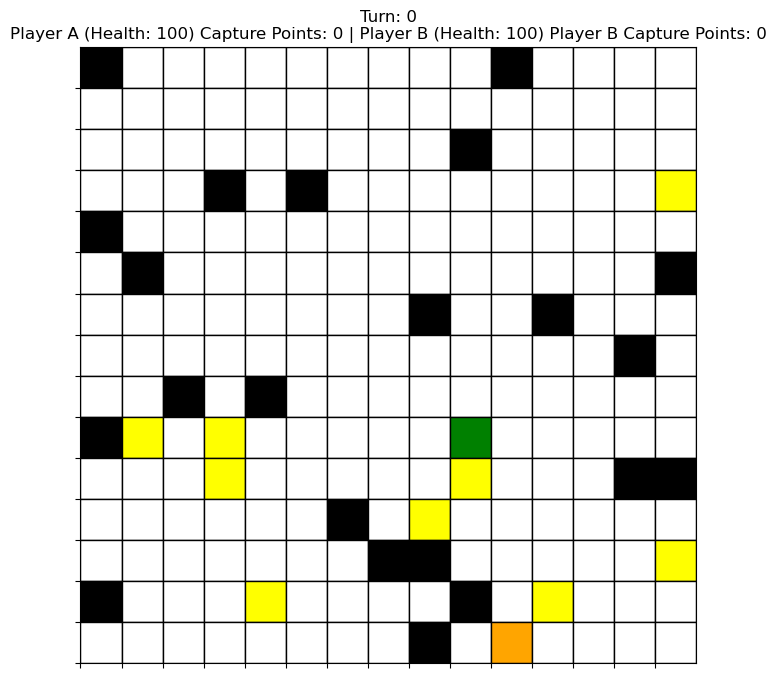

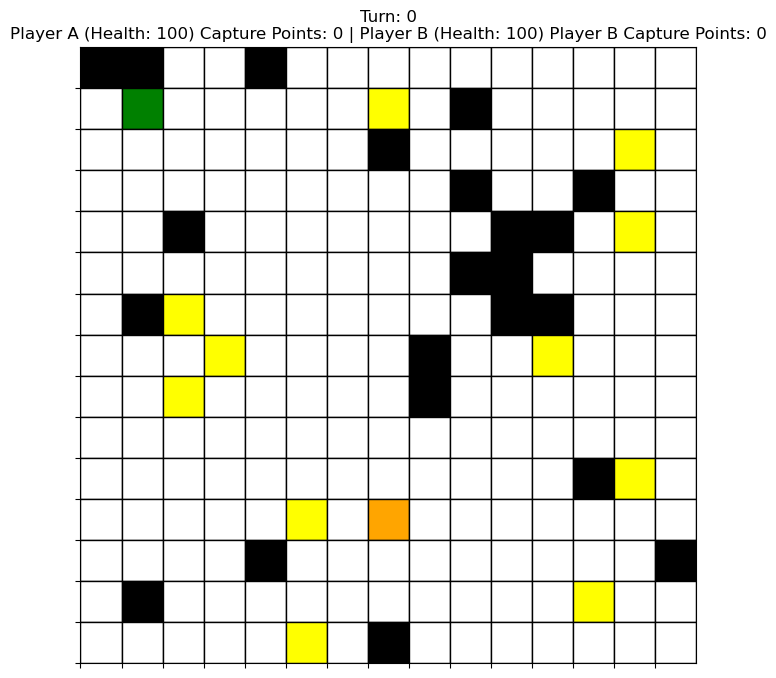

In [7]:
if __name__ == "__main__":
    env = CombatArenaEnv()
    agent_A = TacticalAgent(name="Tactical A")
    agent_B = TacticalAgent(name="Random B")
    
    vis = GameVisualizer(env)

    obs = env.reset()
    done = False
    
    vis.capture_frame()
    
    while not done:

        obs_A = env.get_observation_for_agent(is_agent_one=True)
        obs_B = env.get_observation_for_agent(is_agent_one=False)
        action_A = agent_A.select_action(obs_A)
        action_B = agent_B.select_action(obs_B)
        
        obs1, obs2, rewards, done, info = env.step((action_A, action_B))
        
        vis.capture_frame()
        print(f"Rewards: {rewards}\n")
    
    vis.save_animation("game_replay.gif", fps=2)